# Machine Learning Engineer Nanodegree
## Capstone project
## Project: Forex trading using Q-learning
## Diego Caramuta



## Introduction
The **main idea behind this project is to build an algorithm that is capable to trade currencies**, and moreover is able to learn how to trade them in a “reasonable” way. In particular, the main objective is to **build a Q-learning algorithm** for trading among four of the top five currencies of the FOREX (US Dollar, Euro, Pound Sterling and Australian Dollar). In this sense, there are some articles and papers that indicate that Reinforcement Learning is a good choice for trading problems. This type of developments belongs to what is called “Automated Trading System”. An Automated Trading System is a computer program that creates orders and automatically submits them to a market center or exchange.

Given data, recorded every minute of currency pair prices since **January 2nd 2017 till July 21th of 2017**, the algorithm should be able to learn how to trade. In particular, the algorithm is going to start at January 2nd 2017 with 1,000 USD and has to decide every point in time (i.e. every minute since data is collected every minute) if it is going to do nothing or which currency pair to buy (EURUSD, AUDUSD or GBPUSD). Therefore, every minute the algorithm has four possible actions that could take, and at the end of the period (July 21th of 2017) we can evaluate if the algorithm obtained benefits or not. It is important to note that each time the algorithm can only take one action and not a combination of different actions. In summary, every minute the algorithm can do nothing or take a position: **(i) to buy EURUSD, (ii) to buy AUDUSD or (iii) to buy GBPUSD**. 

On the other hand, the algorithm is going to **close all open positions of a currency pair (i.e. to sell the currency pair) automatically** when it gains at least 0.1 USD by closing them. For example, if the algorithm has 500 open positions to buy AUDUSD then it will close all of them (i.e. to sell 500 AUDUSD) when the gain for selling them is at least 0.1 USD. This automatization of the process of selling positions is a simplification of the problem; this allows the algorithm to focus only on buying. In other words, the algorithm will be betting on price increments of the currency pairs (if prices are decreasing it shouldn't buy and if they are increasing it should buy).

In addition, I'm going to consider a **leverage ratio of 10:1**, this means that the algorithm investment in positions (or open positions) could be at most 10 times the wealth. In other words, if at a point in time the algorithm has a wealth of 100 USD then it can maintain 1,000 USD in open positions (if it has more than this, it is not allowed to buy more positions until it closes the exceeding positions).

Finally, I'm going to say that the Q-learning algorithm has **traded in a "reasonable" way** when it obtains benefits that are greater than the benefits obtained by an algorithm that randomly chooses which action to take each time.

>**Note 1:** In the original proposal I considered the trading among the top five currencies, but I have simplified the approach to only four of the top five (Japanese Yen is not considered) in order to minimize the number of states and actions. Also, in the original proposal, I proposed to consider the commissions that are charged each time a transaction takes place. But I discarded this idea because it penalizes the algorithm that makes random transactions, unless I introduced some logic in order to minimize the cost of the commissions. Given that this minimization problem is not trivial, and may introduce some bias in the logic of the random algorithm, I decided to simulate the problem with no commissions. It is important to mention that, some trading platforms only charge per transaction the spread (difference between the ask and bid price) and no other commission. Therefore, the simulation without a complex commission framework is not an unreal exercise.

>**Note 2:** In order to run this code, you will need the following files:
(i) forex2017_top5.txt: contains FOREX data from January 2017 to July 27th 2017.
(ii) Caramuta_capstone_training_FINAL.py: contains the code that is used for training the Q-learning agent. This code will output the Q funtion that is going to be used during the testing.
(iii) Caramuta_capstone_testing_FINAL.py : contains the code that is used for testing the Q-learning agent and that is used for running the agent that makes random choices.

## Data Exploration
Before we start developing the trading algorithm, we are going to start exploring the data. Thus, let's take a look at the table containing the data. 

First, we read the table:

In [18]:
import pandas as pd    
forex = pd.read_table('forex2017_top5.txt', sep=';')
print 'The number of records is:',len(forex)

The number of records is: 205396


**The table has 205,396 records**. The columns are:

In [19]:
print 'Columns:',list(forex)

Columns: ['order', 'datetime', 'AUDUSD_bid', 'AUDUSD_ask', 'EURUSD_bid', 'EURUSD_ask', 'GBPUSD_bid', 'GBPUSD_ask', 'USDJPY_bid', 'USDJPY_ask']


So **the table has 10 columns**: 

(i) the 'order' column is the row number, 

(ii) the 'datetime' column contains the date and time of the record, 

(iii) the 'AUDUSD_bid' column contains the bid price (i.e. selling price) of the AUDUSD position, 

(iv) the 'AUDUSD_ask' contains the ask price (i.e. buying price) of the AUDUSD position, 

(v) the 'EURUSD_bid' column contains the bid price (i.e. selling price) of the EURUSD position, 

(vi) the 'EURUSD_ask' contains the ask price (i.e. buying price) of the EURUSD position, 

(vii) the 'GBPUSD_bid' column contains the bid price (i.e. selling price) of the GBPUSD position, 

(viii) the 'GBPUSD_ask' contains the ask price (i.e. buying price) of the GBPUSD position, 

(ix) the 'USDJPY_bid' column contains the bid price (i.e. selling price) of the USDJPY position, 

(x) the 'USDJPY_ask' contains the ask price (i.e. buying price) of the USDJPY position. 

On the other hand, **the period of time that is taken into this exercise is the following:**

In [17]:
print 'The max datetime is:', max(forex.datetime)
print 'The min datetime is:', min(forex.datetime)

The max datetime is: 20170721 1659
The min datetime is: 20170102 0200


Let's **plot the ask prices of the three positions** that are going to be used in this exercise:

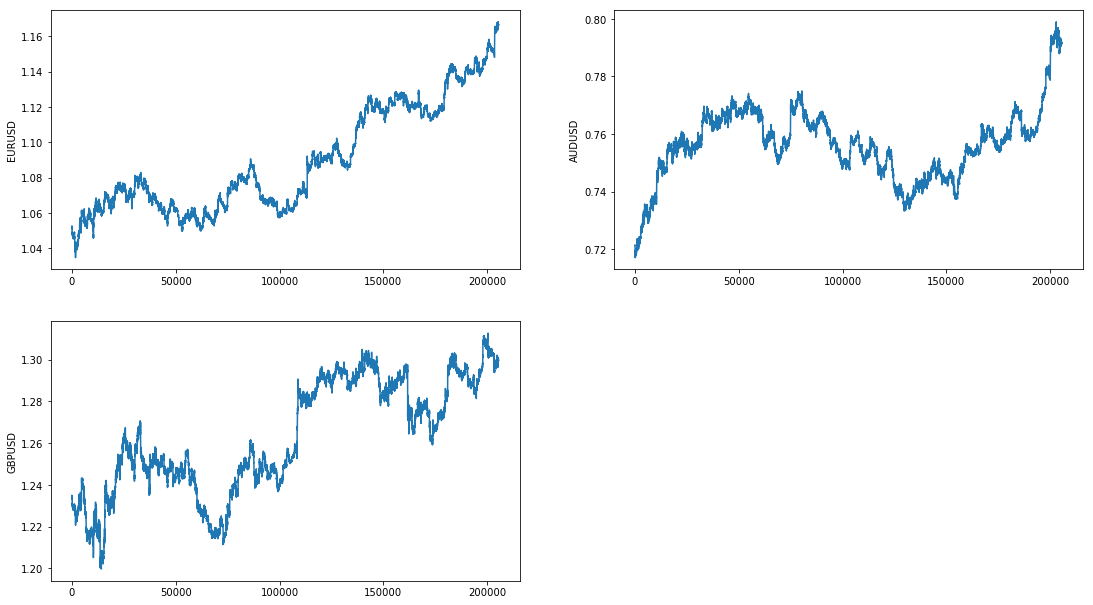

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.figure(1)
plt.subplot(221)
plt.plot(forex.order,forex.EURUSD_ask);
plt.ylabel('EURUSD')
plt.subplot(222)
plt.plot(forex.order,forex.AUDUSD_ask);
plt.ylabel('AUDUSD')
plt.subplot(223)
plt.plot(forex.order,forex.GBPUSD_ask);
plt.ylabel('GBPUSD')
plt.show()

As we can see **the trend of the three prices is positive**. Therefore, if the algorithm buys any position at the beginning and then close the position (i.e. sell the position) at the end of the period it will obtain a positive benefit.

As I explained in the introduction of this document, by default we are going to close all open positions of a currency pair  automatically when we gain at least 0.1 USD by closing them. Therefore, the algorithm should only focus on buying positions. Then, in order to obtain benefits, the algorithm should buy those positions that are going to experiment an important increase on price in a short period of time. 

On the other hand, since the algorithm can not maintain an unlimited ammount of open positions (as I explained in the introduction, the leverage ratio that is allowed is 10:1) then it should choose wisely which positions it should buy in order to obtain the maximum revenues that are possible.

## Implementing a basic trading agent

We are going to start developing a trading agent that is going to **choose randomly among the following actions**: (i) do nothing, (ii) buy EURUSD, (iii) buy AUDUSD or (iv) buy GBPUSD. How much to buy of a position is going to be a parameter (that we are going to set to 100 USD). But before we start, **we are going to split the data into training and test sets**.

We are going to train the Q-learning agent using the first three months of data, i.e. January, February and March. On the other hand, the test set is going to contain April, June and July.

**The following code will run the basic trading agent in the test set.** The results obtained are going to be compared with the results obtained by the Q-learning agent in the test set.

Index: 0 , % of evolution: 0 , Assets: 0 ,  Balance is: 1000
Index: 10000 , % of evolution: 8 , Assets: 10620 ,  Balance is: 1012
Index: 20000 , % of evolution: 17 , Assets: 11008 ,  Balance is: 1045
Index: 30000 , % of evolution: 26 , Assets: 12034 ,  Balance is: 1188
Index: 40000 , % of evolution: 35 , Assets: 12194 ,  Balance is: 1052
Index: 50000 , % of evolution: 44 , Assets: 12224 ,  Balance is: 1183
Index: 60000 , % of evolution: 53 , Assets: 12584 ,  Balance is: 1189
Index: 70000 , % of evolution: 62 , Assets: 3977 ,  Balance is: 1336
Index: 80000 , % of evolution: 70 , Assets: 14729 ,  Balance is: 1366
Index: 90000 , % of evolution: 79 , Assets: 2781 ,  Balance is: 1539
Index: 100000 , % of evolution: 88 , Assets: 5262 ,  Balance is: 1649
Index: 110000 , % of evolution: 97 , Assets: 17527 ,  Balance is: 1702
Index: 112824  FINISH!!!! , Assets: 17757 ,  Balance is: 1719


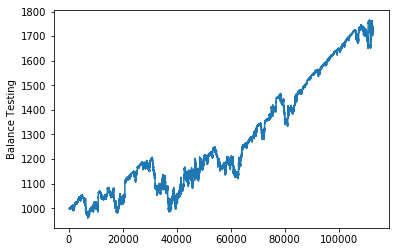

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import Caramuta_capstone_testing_FINAL as caps_testing

caps_testing.test(data_path = 'forex2017_top5.txt', 
      save_Q_path = 'x', #if learning if not any path
      load_Q_path = 'x', #if learning if not any path
      minutes_history = 360, #it is not going to trade after this minutes has passed. this is also the length of the historical data of prices
      dollarstoinv = 100, #amount of dollars to invest in each transaction
      USreserve = 200, #minimum of dollars to keep
      USDwealth = 1000, #amount of dollars to invest
      min_gain = 0.1, #minimum gain to obtain in order to close open positions
      qlearn = 0, #1 if it is going to learn, 0 if not 
      alpha = 0.5) #the learning factor

As we can see, the performance of the basic trading agent is very impressive. The leverage and the positive trend of most of the prices explain this result. In another context, when trends are negative this extreme leverage could cause important losses.

Most of the time the basic agent was buying positions, for example at the iteration 60,000 it kept 12,584 USD in open positions. Therefore, it was most of the time at the maximum leverage allowed. 

As we said earlier, the result obtained by the basic agent is going to be the reference that we are going to use to compare the result obtained by the Q-learning agent. Therefore, **a "reasonable" Q-learning agent must obtain at least the same result**, i.e. it must obtain at least 1,719 USD.

## Implementing a Q-learning trading agent
### Define a State Space

One of the first steps in order to develop a Q-learning agent is to define the set of states. And, in order to have a set of states that can be meaningful for a trading agent, we need to provide information about what is happening with positions' prices. Hence, **we are going to keep some history of the evolution of prices**, that is going to be used to compute the states (the length of historical data is a parameter that is set at 360 minutes, i.e. 6 hours).

I am going to define the set of states in the following way: 

**state = (trend_EURUSD, stats_EURUSD, trend_AUD, stats_AUDUSD, trend_GBP, stats_GBPUSD, greater_trend)**

The trend_EURUSD, trend_AUDUSD and trend_GBPUSD are variables that capture the trend of each of the prices of these positions. Each of these variables can take only two values, 1 if the trend is positive and -1 if the trend is zero or negative.

The stats_EURUSD, stats_AUDUSD and stats_GBPUSD are variables that capture if the prices are near the mean, at the maximum, or at the minimum. Each of these variables can take four values: 0 if the price is between the mean and one standar deviation, 1 if the price is below the mean minus one standar deviation, 2 if the price is at a minimum, -1 if the price is above the mean plus one standar deviation, and -2 if the price is at a maximum.

Finally, greater_trend captures which of the trends is greater. It can take four values: 3 if the trend of the EURUSD is the greatest, 2 if the trend of the AUDUSD is the greatest, 1 if the trend of the GBPUSD is the greatest, and 0 if none of the previous conditions are satisfied.  

Therefore, since each of the three trend variables can take two values, each of the stats variables can take 5 values and the greater_trend variable can take four values, then **the total number of states is 4,000** ($2^3 \times 5^3 \times 4 = 4,000$).

The agent is going to be able to learn a policy for each posible state if the agent is able to face each state at least once during the training trials. In particular, for each state there are 4 valid actions, and in order to learn the best action in each state, **the agent would have to iterate at least 4,000 x 4 = 16,000 times** to get the right one.

### The exploration factor

Now we are going to define the epsilon (the exploration factor). The epsilon is important because when an action is selected in training, it is either chosen as the action with the highest Q-value, or a random action. Choosing between these two is random and based on the value of epsilon, each time the agent has to choose an action the epsilon is compared to a random number and if the epsilon is greater than the random number then a random action is taken, otherwise the action with the highest Q-value is chosen.

During testing, we are going to use this same method but with epsilon at a very low value (0.05), such that there is a strong bias towards exploitation over exploration. However, 5% of the time random actions are still chosen.

We are going to consider the following decaying function for epsilon during training:

$$ \epsilon = a^t, \textrm{ for  } 0 < a < 1 $$

In particular, we have chosen: $$a = 0.99998$$

Setting $a$ at this value allows us to have a function that slowly decays and approaches a value near zero after 100,000 minutes, which is approximately three months (considering only business days, and in our particular case, this will be January to March). Next we graph the epsilon function.

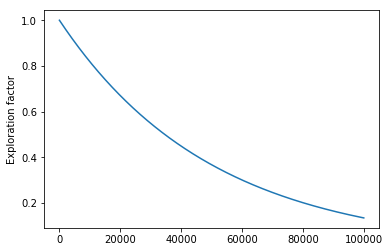

In [2]:
import pandas as pd
epsilon_hist = pd.DataFrame(columns=['x', 'epsilon'])
for x in range(0, 100000):
    epsilon = 0.99998**(x+1)
    epsilon_append = pd.DataFrame({'x':[x], 'epsilon':[epsilon]})
    epsilon_hist = epsilon_hist.append(epsilon_append, ignore_index=True)
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(epsilon_hist.x,epsilon_hist.epsilon)
plt.ylabel('Exploration factor')
plt.show()

### The rewards and the Q

The Q function in the code is a dictionary where each state will be a key of the dictionary, and each value will then be another dictionary that holds the action and Q-value. The Q-value for each actions is updated using the following formula:

$$ Q_{new}(s_t, a_t) = (1 - \alpha) \times Q_{old}(s_t, a_t) + \alpha \times reward $$

where $\alpha$ (the learning factor) is going to be fixed at $0.5$ during training, during testing we are going to consider $\alpha=0.25$.

On the other hand, the rewards are not going to be computed immediately after an action is taken, instead we are going to compute the rewards after $x$ minutes have passed since the action has been chosen (we are going to set $x$ to 360, i.e., 6 hours). Since gains and losses do not materialize immediately, we need some time to see if an action was "beneficial" or not.

We are going to assign a **reward** each time we buy a position in the following way: 

(i) if it was sold after $x$ amount of minutes and the selling price was higher than the buying price then the reward is 2, 

(ii) if it was sold after $x$ amount of minutes and the selling price was higher than the buying price and the gain obtained is higher than the gain that we could have obtained by buying another position then the reward is 3, 

(iii) if it was sold after $x$ amount of minutes and the selling price was equal than the buying price then the reward is 0, 

(iv) if it was sold after $x$ amount of minutes and the selling price was lesser than the buying price then the reward is -1, 

(v) if it was not sold after $x$ amount of minutes then the reward is -1.


Finally, each time we do nothing is going to have a reward equal to zero.

### The results of the Q-learning trading agent
**Training.** First, we are going to train the agent. The following code will run the training and records the Q-function that is going to be used in the testing exercise.

Index: 0 , % of evolution: 0 , Assets: 0 ,  Balance is: 1000
Index: 10000 , % of evolution: 10 , Assets: 10557 ,  Balance is: 946
Index: 20000 , % of evolution: 21 , Assets: 10332 ,  Balance is: 1151
Index: 30000 , % of evolution: 32 , Assets: 12663 ,  Balance is: 1189
Index: 40000 , % of evolution: 43 , Assets: 13274 ,  Balance is: 1263
Index: 50000 , % of evolution: 54 , Assets: 13327 ,  Balance is: 1228
Index: 60000 , % of evolution: 64 , Assets: 13220 ,  Balance is: 1121
Index: 70000 , % of evolution: 75 , Assets: 13298 ,  Balance is: 1199
Index: 80000 , % of evolution: 86 , Assets: 1289 ,  Balance is: 1409
Index: 90000 , % of evolution: 97 , Assets: 14404 ,  Balance is: 1375
Index: 92570  FINISH!!!! , Assets: 14318 ,  Balance is: 1289


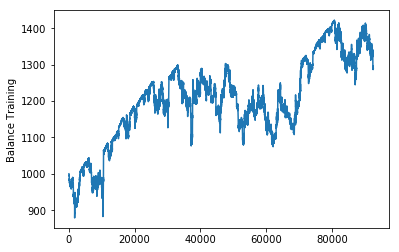

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import Caramuta_capstone_training_FINAL as caps_train
caps_train.train(data_path = 'forex2017_top5.txt',
      save_Q_path = 'Q_capstone', #if learning if not any path
      save_Q_path2 = 'Q_capstone.txt', #if learning if not any path
      minutes_history = 360, #it is not going to trade after this minutes has passed. this is also the length of the historical data of prices
      dollarstoinv = 100, #amount of dollars to invest in each transaction
      USreserve = 200, #minimum of dollars to keep
      USDwealth = 1000, #amount of dollars to invest
      min_gain = 0.1, #minimum gain to obtain in order to close open positions
      qlearn = 1, #1 if it is going to learn, 0 if not
      alpha = 0.5) #the learning factor

The output of the training exercise is the Q function that is going to be used during the testing exercise. We **can explore the Q**, since the Q_capstone.txt file contains the readable Q. In this file, for example, we could see the following:

(-1, 0, 1, 1, 1, 0, 1)

 -- nothing : 0.00

 -- buyGBPUSD : 0.14

 -- buyEURUSD : -0.50

 -- buyAUDUSD : 0.00

This means that the state is: (-1, 0, 1, 1, 1, 0, 1). That is: the trend of AUDUSD and GBPUSD are positive, the trend of EURUSD is negative, the price of GBPUSD is rising faster than the price of AUDUSD, and the price of GBPUSD is between the mean and the standar deviation. Given this state, the action with the highest Q-value is buy GBPUSD.


**Testing.** Second, using the Q function generated in the training exercise we test the Q-learning agent. The following code will run the Q-learning trading agent in the test set. The results obtained are going to be compared with the results obtained by the basic trading agent.

>**Note:** It is important to mention that during the testing we are going to maintain a fixed $\epsilon$ equal to 0.05, and we are going to set $\alpha=0.25$.

Index: 0 , % of evolution: 0 , Assets: 0 ,  Balance is: 1000
Index: 10000 , % of evolution: 8 , Assets: 4092 ,  Balance is: 1076
Index: 20000 , % of evolution: 17 , Assets: 11215 ,  Balance is: 1079
Index: 30000 , % of evolution: 26 , Assets: 7553 ,  Balance is: 1234
Index: 40000 , % of evolution: 35 , Assets: 12963 ,  Balance is: 1192
Index: 50000 , % of evolution: 44 , Assets: 198 ,  Balance is: 1374
Index: 60000 , % of evolution: 53 , Assets: 14337 ,  Balance is: 1357
Index: 70000 , % of evolution: 62 , Assets: 6165 ,  Balance is: 1548
Index: 80000 , % of evolution: 70 , Assets: 16351 ,  Balance is: 1516
Index: 90000 , % of evolution: 79 , Assets: 6358 ,  Balance is: 1674
Index: 100000 , % of evolution: 88 , Assets: 595 ,  Balance is: 1780
Index: 110000 , % of evolution: 97 , Assets: 18715 ,  Balance is: 1790
Index: 112824  FINISH!!!! , Assets: 396 ,  Balance is: 1885


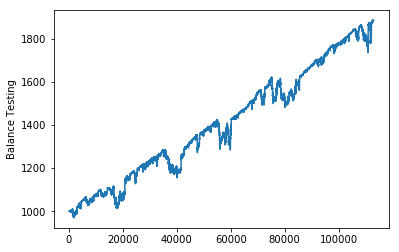

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import Caramuta_capstone_testing_FINAL as caps_testing
caps_testing.test(data_path = 'forex2017_top5.txt',
      save_Q_path = 'Q_capstone_test', #if learning if not any path
      load_Q_path = 'Q_capstone.npy', #if learning if not any path
      minutes_history = 360, #it is not going to trade after this minutes has passed. this is also the length of the historical data of prices
      dollarstoinv = 100, #amount of dollars to invest in each transaction
      USreserve = 200, #minimum of dollars to keep
      USDwealth = 1000, #amount of dollars to invest
      min_gain = 0.1, #minimum gain to obtain in order to close open positions
      qlearn = 1, #1 if it is going to learn, 0 if not 
      alpha = 0.25) #the learning factor

Finally, we obtained a Q-learning trading agent that obtained a result that is greater than the one that was obtained by the basic trading agent (remember that the result obtained by the basic agent was 1,719 USD, and 1,885 is the result obtained by the Q-learning agent). Moreover, in the whole testing period the Q-learning agent obtained better results than the ones obtained by the basic agent. Thus, **we obtained a Q-learning agent that traded in a "reasonable" way**.